Setup

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import math
import os
import time

os.makedirs('./tmp', exist_ok=True)
os.makedirs('./output', exist_ok=True)
os.makedirs('./tmp/interations', exist_ok=True)

MIN_METRO_CITY_RADIUS = 10
MAX_METRO_CITY_RADIUS = 100 - MIN_METRO_CITY_RADIUS
# Theory says that a metropolis is a city with more than 500k residents, 
# but for the given example we count Gdańsk as a metropolis so I took 400k as a minimum
MIN_METROCITIES_POPULATION = 500000

# Columns names from http://download.geonames.org/export/dump/
columns = [
    "geonameid",
    "name", 
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "feature_class",
    "feature_code",
    "country_code",
    "cc2",
    "admin1_code",
    "admin2_code",
    "admin3_code",
    "admin4_code",
    "population",
    "elevation",
    "dem",
    "timezone",
    "modification_date"
]

data = pd.read_csv(
    "./data/PL.txt",
    sep='\t',
    names=columns,
    dtype={
        "admin1_code": "str",
        "admin2_code": "str",
        "admin3_code": "str",
        "admin4_code": "str"
    }
)

Prepare data

In [12]:
# Check if all records contains name
# print(len(data))
# data.dropna(subset=['name'], inplace=True)
# print(len(data))

# Filter only locations which are cities, towns, villages, etc. (http://www.geonames.org/export/codes.html)
populatedPlaces = data.loc[data["feature_code"].isin(["PPL", "PPLF", "PPLA", "PPLA2", "PPLA3", "PPLA4", "PPLA5", "PPLS", "ADM2"])]


# any([x in a_string for x in matches])
# Analyze only required data 
populatedPlaces = populatedPlaces[["geonameid", "name", "population", "latitude", "longitude", "feature_code", "modification_date", "admin1_code", "admin2_code"]]

# Remove places with missing values
populatedPlaces.dropna(subset=["geonameid", "latitude", "longitude", "population"], inplace=True)

# Remove places which population equals to zero
# populatedPlaces.drop(populatedPlaces[populatedPlaces["population"] == 0].index, inplace=True)

# Simple manual data filtering

illegalWords = [
    "Powiat ",
    "Las "
]

for word in illegalWords:
    populatedPlaces = populatedPlaces[~populatedPlaces["name"].str.contains(word, case=False)]

# Remove duplicates
populatedPlaces = populatedPlaces.sort_values(by=["name", "feature_code", "modification_date"])
populatedPlaces.to_csv("./tmp/places-with-duplicates.csv")

populatedPlaces.drop_duplicates(subset=["name", "admin1_code", "admin2_code"], keep="last", inplace=True)

# Prepare columns for future use
populatedPlaces["radius_to_metrocity"] = 0 # radius to the metrocity
populatedPlaces["belongs_to_metrocity"] = "" # Name of the metrocity to which the city belongs
populatedPlaces["belongs_to_metrocity_id"] = "" # geonameid of the metrocity to which the city belongs
populatedPlaces["metrocity_impact"] = 0 # impact of the metrocity to which the city belongs
populatedPlaces["metrocity_population"] = populatedPlaces["population"] # population of city + all cities which belongs to this city

populatedPlaces.to_csv("./tmp/places.csv")

print(populatedPlaces)

       geonameid                    name  population  latitude  longitude   
23736     776807              Abramowice           0  49.79212   20.19428  \
53863    8426056  Abramowice (dzielnica)           0  51.19529   22.57819   
23735     776806    Abramowice Kościelne           0  51.20000   22.58333   
23734     776805     Abramowice Prywatne           0  51.20527   22.62068   
23732     776803                  Abramy           0  53.00900   21.85009   
...          ...                     ...         ...       ...        ...   
209       753136                  Żłobek           0  49.34481   22.68917   
305       753232                  Żłobek           0  51.46667   23.58333   
304       753231            Żłobek Drugi           0  51.46399   23.56705   
24028    3080105                Żłobizna           0  50.84270   17.45813   
24027    3080104                Żłobnica           0  51.22774   19.25285   

      feature_code modification_date admin1_code admin2_code   
23736      

Create 2 data sets (metrocities and non-metrocities)

In [9]:
populatedPlaces["is_metrocity"] = populatedPlaces.apply(lambda r: 1 if r["population"] >= MIN_METROCITIES_POPULATION else 0, axis=1)

metrocities = populatedPlaces[populatedPlaces["population"] >= MIN_METROCITIES_POPULATION]
nonMetrocities = populatedPlaces[populatedPlaces["population"] < MIN_METROCITIES_POPULATION]
print(metrocities)

       geonameid      name  population  latitude  longitude feature_code   
38634    3094802    Kraków      755050  50.06143   19.93658         PPLA  \
32047    3088171    Poznań      570352  52.40692   16.92993         PPLA   
49044    6695624  Warszawa     1794166  52.23547   21.04191         ADM2   
25287    3081368   Wrocław      634893  51.10000   17.03333         PPLA   
36976    3093133      Łódź      768755  51.77058   19.47395         PPLA   

      modification_date admin1_code admin2_code  radius_to_metrocity   
38634        2020-09-18          77        1261                    0  \
32047        2020-05-21          86        3064                    0   
49044        2022-04-04          78        1465                    0   
25287        2021-10-06          72        0264                    0   
36976        2020-12-19          74        1061                    0   

      belongs_to_metrocity belongs_to_metrocity_id  metrocity_impact   
38634                                 

In [ ]:
def distance_to_metro_city(lat1, lon1, lat2, lon2):
    # Haversine formula
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371 # Radius of earth in km
    
    return r * c

distancesDict = {}

for _, metrocity in metrocities.iterrows():
    distancesDict[metrocity["geonameid"]] = None

for _, city in nonMetrocities.iterrows():
    for _, metrocity in metrocities.iterrows():
        distance = distance_to_metro_city(city["latitude"], city["longitude"], metrocity["latitude"], metrocity["longitude"])
        if distance <= MAX_METRO_CITY_RADIUS:
            if distancesDict[metrocity["geonameid"]] is None:
                distancesDict[metrocity["geonameid"]] = pd.DataFrame(None, columns=["distance"])

            distancesDict[metrocity["geonameid"]].loc[city["geonameid"]] = [distance]
            
print(distancesDict)

Helpers definition

In [13]:
def radius(population):
    METRO_CITY_POPULATION_CONSTANT = -1/1443000
    return MIN_METRO_CITY_RADIUS + MAX_METRO_CITY_RADIUS * (1 - np.exp(METRO_CITY_POPULATION_CONSTANT * population))

def _calcualate_metrocity_impact(max_radius, distance_to_metro_city):
    METRO_CITY_POWER_CONSTANT = -1.4
    impact = np.exp(METRO_CITY_POWER_CONSTANT  * distance_to_metro_city / max_radius)
    return impact

def find_metrocity(row):
    for index, metrocity in metrocities.iterrows():
        try:
            distance = distancesDict[metrocity["geonameid"]].loc[row["geonameid"]]["distance"]
            radius = metrocity["metrocity_radius"]
            impact = _calcualate_metrocity_impact(radius, distance)

            if distance < radius and impact > row["metrocity_impact"]:
                metrocities.loc[metrocities["geonameid"] == metrocity["belongs_to_metrocity_id"], 'metrocity_population'] -= row["population"]

                row["metrocity_impact"] = impact
                row["belongs_to_metrocity_id"] = metrocity["geonameid"]
                row["belongs_to_metrocity"] = metrocity["name"]

                metrocities.loc[metrocities["geonameid"] == metrocity["geonameid"], 'metrocity_population'] += row["population"]

                changes.append(index)
        except:
            continue
    
    return row

Assigning cities to metrocities

In [14]:
changes = [0]

i = 0

while len(changes) != 0:
    start_time = time.time()
    changes = []
    metrocities.loc[:, "metrocity_radius"] = metrocities.apply(lambda r: radius(r["metrocity_population"]), axis=1)
    nonMetrocities.loc[:, :] = nonMetrocities.apply(find_metrocity, axis=1)
    pd.concat([metrocities, nonMetrocities]).to_csv(f"./tmp/interations/{i}.csv")
    i += 1
    print(f"Interation: {i}, changes: {len(changes)}, time: {time.time() - start_time}")
    
pd.concat([metrocities, nonMetrocities]).to_csv(f"./output/results.csv")

Interation: 1, changes: 8009, time: 25.608752250671387
Interation: 2, changes: 12668, time: 29.24601697921753
Interation: 3, changes: 16626, time: 35.80579996109009
Interation: 4, changes: 19082, time: 37.58140230178833


KeyboardInterrupt: 

Load map shape

In [ ]:
geomap = gpd.read_file('./data/pol_admbnda_adm0_gov_v02_20220414.shp')

Draw metrocities map

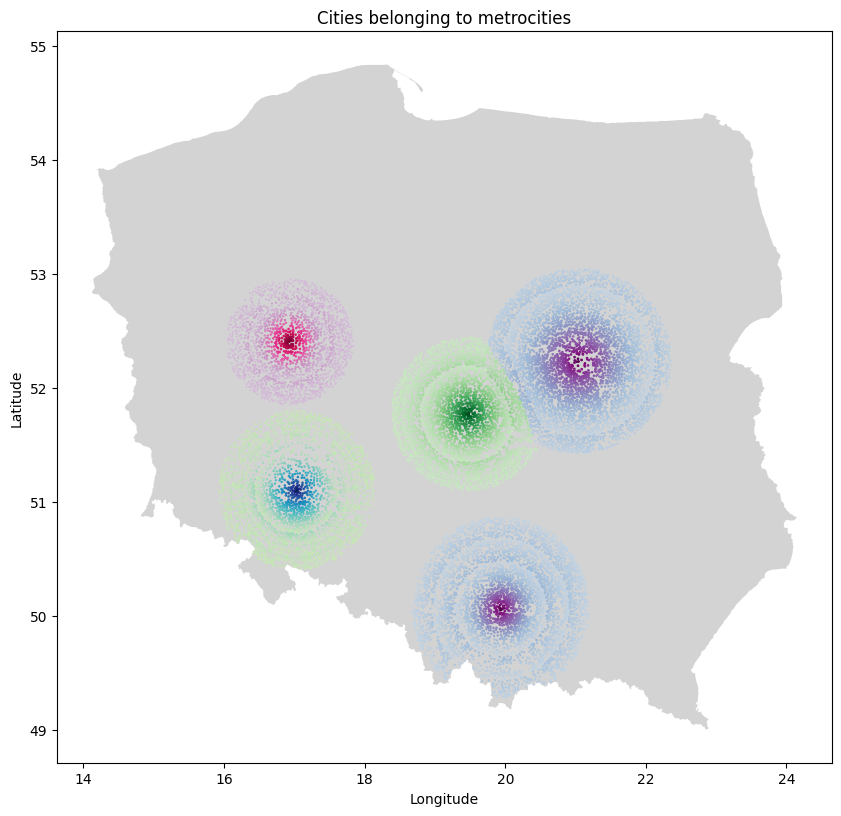

In [7]:
cmaps = ['Purples', 'Greens', 'Oranges', 'Reds',
          'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
          'GnBu', 'PuBu', 'YlGnBu', 'BuGn', 'YlGn']

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(10, 10))
geomap.plot(color="lightgrey", ax=ax)

for index, city in metrocities.iterrows():
    cmap = cmaps[index % len(cmaps)]
    
    plt.scatter([city["longitude"]], [city["latitude"]], s=1, c=1, vmin=0, vmax=1, cmap=cmap)
    
    x = nonMetrocities[nonMetrocities["belongs_to_metrocity_id"] == city["geonameid"]]["longitude"]
    y = nonMetrocities[nonMetrocities["belongs_to_metrocity_id"] == city["geonameid"]]["latitude"]
    impact = nonMetrocities[nonMetrocities["belongs_to_metrocity_id"] == city["geonameid"]]["metrocity_impact"]

    plt.scatter(x, y, s=impact, c=impact, vmin=0, vmax=1, cmap=cmap)

plt.title("Cities belonging to metrocities")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
